# Проектирование признаков

In [564]:
import pandas as pd 
import numpy as np
import category_encoders as ce

In [565]:
data = pd.read_csv('data/wine_cleared.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            129971 non-null  object 
 4   points                 129971 non-null  int64  
 5   price                  129971 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               129971 non-null  object 
 8   taster_name            129971 non-null  object 
 9   taster_twitter_handle  129971 non-null  object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 12.9+ MB


## РАЗБОР ЧИСЛОВЫХ ВЕЛИЧИН

В наборе данных очень часто встречаются числовые величины. Это могут быть вес, рост, расстояние и так далее. Вы можете преобразовывать их, создавать новые признаки, которые могут оказаться лучше исходных.

Например, в датасете винных обзоров числовым признаком является цена за бутылку вина. Вы можете округлить цену 35.363389$ в 35$, избавив данные от лишней информации.

In [566]:
data['price_round'] = data['price'].round().astype('int')

## РАЗБОР ТЕКСТА И КАТЕГОРИЙ

In [567]:
regex = '\d{4}' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)

In [568]:
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)

Создайте новый бинарный признак old_wine, где значение 1 будет обозначать, что вино старше 2010 года.

In [569]:
data['year'] = pd.to_datetime(data['year'], errors='coerce')
data['old_wine'] = data['year'].apply(lambda x: 1 if x.year < 2010 else 0)
data['old_wine'].sum()


39765

Создайте новый признак locality из признака title, который будет обозначать название долины/местности производства вина.

Например, в названии вина Rainstorm 2013 Pinot Gris (Willamette Valley) locality будет Willamette Valley. В названии Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra) — Navarra.

In [570]:
data['locality'] = data['title'].str.findall(r'(?<=\().+?(?=\))').str.get(0)
data['locality'].tail()

129966    Erben Müller-Burggraef
129967                    Oregon
129968                    Alsace
129969                    Alsace
129970                    Alsace
Name: locality, dtype: object

## РАБОТА С ФАЙЛАМИ

In [571]:
country_population = pd.read_csv('data/country_population.zip', sep=';')
country_population

,country,population
0,China,"1,411,778,724"
1,India,"1,386,584,581"
2,US,"333,022,386"
3,Indonesia,"271,350,000"
4,Pakistan,"225,200,000"
...,...,...
236,Niue,"1,549"
237,Tokelau,"1,501"
238,Vatican City,825
239,Cocos Islands,573


Каково население Италии согласно датасету country_population? Ответ вводите без пробелов и запятых.

In [572]:
country_population[country_population['country']=='Italy']

,country,population
24,Italy,"59,097,904"


Далее сопоставим значения из датасета country_population и страной-производителем вина. На основе значений населения из country_population заполним новый признак country_population.

In [573]:
data = data.join(country_population.set_index('country'), on='country')
data.rename(columns={'population':'country_population'}, inplace=True)

Теперь используем файл country_area.zip для информации о площади страны.

In [574]:
country_area = pd.read_csv('data/country_area.zip', sep=';')
country_area

,country,area
0,Russia,17075400.00
1,Canada,9984670.00
2,China,9596960.00
3,US,9372610.00
4,Brazil,8547000.00
...,...,...
188,San Marino,61.00
189,Tuvalu,26.00
190,Nauru,21.00
191,Monaco,2.00


In [575]:
data = data.join(country_area.set_index('country'), on='country')
data.rename(columns={'area':'area_country'}, inplace=True)

Какая площадь страны у вина под названием 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'? Ответ вводите без пробелов, округлите до целых.

In [576]:
mask = data['title'] == 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'
data[mask][['country', 'country_population', 'area_country']]

,country,country_population,area_country
94,US,"333,022,386",9372610.0


## Работа с форматом «дата-время»

В следующих заданиях мы будем использовать срез базы данных из колл-центра. Компания хочет предсказывать, какому из клиентов стоит звонить сегодня, а какому — нет.
* client_id — идентификатор клиента в базе;
* agent_date — время соединения с агентом;
* created_at — время соединения с клиентом (начало разговора);
* end_date — время окончания соединения с клиентом (конец разговора).

In [577]:
# инициализируем информацию о звонках
calls_list = [
    [460, '2013-12-17 04:55:39', '2013-12-17 04:55:44', '2013-12-17 04:55:45'],
    [12, '2013-12-16 20:03:20', '2013-12-16 20:03:22', '2013-12-16 20:07:13'],
    [56, '2013-12-16 20:03:20', '2013-12-16 20:03:20', '2013-12-16 20:05:04'],
    [980, '2013-12-16 20:03:20','2013-12-16 20:03:27', '2013-12-16 20:03:29'],
    [396, '2013-12-16 20:08:27', '2013-12-16 20:08:28','2013-12-16 20:12:03'],
    [449, '2013-12-16 20:03:20', '2013-12-16 20:03:25','2013-12-16 20:05:00'],
    [397, '2013-12-16 20:08:25', '2013-12-16 20:08:27', '2013-12-16 20:09:59'],
    [398, '2013-12-16 20:01:23', '2013-12-16 20:01:23', '2013-12-16 20:04:58'],
    [452, '2013-12-16 20:03:20', '2013-12-16 20:03:21','2013-12-16 20:04:55'],
    [440, '2013-12-16 20:03:20', '2013-12-16 20:04:26', '2013-12-16 20:04:32']
]

calls = pd.DataFrame(calls_list, columns = ['client_id',  'agent_date', 'created_at' ,'end_date'])

# преобразовываем признаки в формат datetime для удобной работы

calls['agent_date'] = pd.to_datetime(calls['agent_date'])
calls['created_at'] = pd.to_datetime(calls['created_at'])
calls['end_date'] = pd.to_datetime(calls['end_date'])

calls

,client_id,agent_date,created_at,end_date
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32


Мы можем посчитать, сколько примерно длилось время разговора клиента и сотрудника компании — длительность разговора. 

Подсчитаем разницу между датой и временем начала разговора с клиентом и датой и временем окончания звонка.

In [578]:
calls['duration'] = (calls['end_date'] - calls['created_at']).dt.seconds
calls

,client_id,agent_date,created_at,end_date,duration
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6


#### 4.1
Подсчитайте, сколько секунд тратят сотрудники компании на дозвон клиенту. Результат запишите в новый признак time_connection.

В ответ запишите результат выполнения следующего кода: calls['time_connection'].sum()

In [579]:
calls['time_connection'] = (calls['created_at'] - calls['agent_date']).dt.seconds
calls['time_connection'].sum()

89

#### 4.2
Создайте новый признак is_connection — факт соединения с клиентом. Признак будет равен 1 в случае, если разговор состоялся и продлился больше 10 секунд, иначе — 0.

В ответ запишите результат выполнения следующего кода: calls['is_connection'].sum()

In [580]:
calls['is_connection'] = calls['duration'].apply(lambda x: 1 if x > 10 else 0)
calls['is_connection'].sum()

7

#### 4.3
Создайте признак time_diff — разницу в секундах между началом звонка(не разговора) и его окончанием.

В ответ запишите результат выполнения следующего кода: calls['time_diff'].sum()

In [581]:
calls['time_diff'] = (calls['end_date'] - calls['agent_date']).dt.seconds
calls['time_diff'].sum()

1144

Итак, мы получили четыре новых признака для нашего набора данных: duration, time_connection, is_connection, time_diff. После генерации признаков из дат исходные признаки agent_date, created_at, end_date нам больше не нужны — передать на вход модели мы им не сможем, так как большинство моделей машинного обучения умеют работать только с числами, даты и текст ей недоступны, поэтому удалим их:

In [582]:
calls = calls.drop(columns=['agent_date', 'created_at' ,'end_date'], axis=1)

Создайте признак количество дней с момента произведения вина — years_diff для датасета винных обзоров. За дату отсчёта возьмите 12 января 2022 года. В ответ впишите максимальное количество дней с момента произведения вина. Ответ округлите до целого числа.

In [583]:
data['years_diff'] = pd.datetime(2022, 1, 12) - data['year']
data['years_diff'].max()

/var/folders/7d/737wrt6574jfhqcjjxv10rnh0000gn/T/ipykernel_3324/3781714725.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  data['years_diff'] = pd.datetime(2022, 1, 12) - data['year']


Timedelta('98627 days 00:00:00')

## Кодирование признаков. Методы

In [584]:
# pip install category_encoders
# import category_encoders as ce

Создадим обучающий набор для кодирования порядковых признаков — ассортимент небольшого магазина с одеждой, где size — буквенное обозначение размера одежды, type — тип изделия.

In [585]:
# инициализируем информацию об одежде
clothing_list = [
    ['xxs', 'dress'],
    ['xxs', 'skirt'],
    ['xs', 'dress'],
    ['s', 'skirt'],
    ['m', 'dress'],
    ['l', 'shirt'],
    ['s', 'coat'],
    ['m', 'coat'],
    ['xxl', 'shirt'],
    ['l', 'dress']
]

clothing = pd.DataFrame(clothing_list, columns = ['size',  'type'])
clothing

,size,type
0,xxs,dress
1,xxs,skirt
2,xs,dress
3,s,skirt
4,m,dress
5,l,shirt
6,s,coat
7,m,coat
8,xxl,shirt
9,l,dress


Выполним теперь кодирование порядкового признака size и type признака в Python. Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder. По умолчанию все строковые столбцы будут закодированы.

Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними. Затем используем метод concat() для добавления закодированного признака в датафрейм data.

In [586]:
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(clothing[['size','type']])
data_bin.rename(columns={'size':'ord_size', 'type':'ord_type'}, inplace=True)
clothing = pd.concat([clothing, data_bin], axis=1)
clothing

,size,type,ord_size,ord_type
0,xxs,dress,1,1
1,xxs,skirt,1,2
2,xs,dress,2,1
3,s,skirt,3,2
4,m,dress,4,1
5,l,shirt,5,3
6,s,coat,3,4
7,m,coat,4,4
8,xxl,shirt,6,3
9,l,dress,5,1


### 5.3
Используйте ранее изученные методы кодирования и закодируйте признак year в датасете винных обзоров порядковым кодированием.

In [587]:
ord_encoder = ce.OrdinalEncoder(cols=['year'])
year_bin = ord_encoder.fit_transform(data['year'])
year_bin

,year
0,1
1,2
2,1
3,1
4,3
...,...
129966,1
129967,12
129968,1
129969,3


Закодируем признак type однократным кодированием.

Закодируем признак type в Python. Используем класс OneHotEncoding библиотеки category_encoders. Укажем в cols наименование признака type для кодировки, иначе будут закодированы все строковые столбцы.

In [588]:
encoder = ce.OneHotEncoder(cols=['type'])
type_bin = encoder.fit_transform(clothing['type'])
type_bin.rename(columns={'type_1':'type_dress', 'type_2':'type_skirt', 'type_3':'type_shirt','type_4':'type_coat'}, inplace=True)
clothing = pd.concat([clothing, type_bin], axis=1)
clothing

,size,type,ord_size,ord_type,type_dress,type_skirt,type_shirt,type_coat
0,xxs,dress,1,1,1,0,0,0
1,xxs,skirt,1,2,0,1,0,0
2,xs,dress,2,1,1,0,0,0
3,s,skirt,3,2,0,1,0,0
4,m,dress,4,1,1,0,0,0
5,l,shirt,5,3,0,0,1,0
6,s,coat,3,4,0,0,0,1
7,m,coat,4,4,0,0,0,1
8,xxl,shirt,6,3,0,0,1,0
9,l,dress,5,1,1,0,0,0


### 5.4
В нашем наборе данных винных обзоров признак, обозначающий имя сомелье (taster_name), является номинальным. Закодируйте его, используя One-Hot Encoding.

В ответе напишите, сколько признаков добавилось после применения кодирования.

In [589]:
encoder = ce.OneHotEncoder(cols=['taster_name'])
taster_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, taster_bin], axis=1)

### Двоичное кодирование
Сначала признак кодируется в числовое представление, как мы делали это при кодировании порядковых признаков: hot — 1, cold — 2, … и так далее.

Затем каждое числовое представление, выраженное целым числом, переводится в двоичный код: 1 – 001, 2 – 010, 3 – 011,... и так далее.

Затем для каждого двоичного представления создаются новые признаки. В нашем случае двоичное представления уместилось в три числа, поэтому итогом стало создание трёх новых признаков.

Пошаговый алгоритм двоичного кодирования можно описать так: 

* значения признака кодируются в некоторый числовой порядок;
* целые числа кодируются в двоичный код;
* цифры двоичного представления формируют новые столбцы.

In [590]:
bin_encoder = ce.BinaryEncoder(cols='type')
type_bin = bin_encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)
clothing

,size,type,ord_size,ord_type,type_dress,type_skirt,type_shirt,type_coat,type_0,type_1,type_2
0,xxs,dress,1,1,1,0,0,0,0,0,1
1,xxs,skirt,1,2,0,1,0,0,0,1,0
2,xs,dress,2,1,1,0,0,0,0,0,1
3,s,skirt,3,2,0,1,0,0,0,1,0
4,m,dress,4,1,1,0,0,0,0,0,1
5,l,shirt,5,3,0,0,1,0,0,1,1
6,s,coat,3,4,0,0,0,1,1,0,0
7,m,coat,4,4,0,0,0,1,1,0,0
8,xxl,shirt,6,3,0,0,1,0,0,1,1
9,l,dress,5,1,1,0,0,0,0,0,1


### 5.5
Вернёмся к нашему примеру с винным датасетом. Признак country содержит много уникальных значений — используем двоичную кодировку признака.

In [591]:
bin_encoder = ce.BinaryEncoder(cols='country')
bin_country = bin_encoder.fit_transform(data['country'])
data = pd.concat([data, bin_country], axis=1)


### 5.8
На основе изученного материала определите подходящий способ кодирования признака taster_twitter_handle из датасета винных обзоров и закодируйте его.

In [592]:
data['taster_twitter_handle'].unique().size
bin_encoder = ce.BinaryEncoder(cols='taster_twitter_handle')
bin_twitter = bin_encoder.fit_transform(data['taster_twitter_handle'])
data = pd.concat([data, bin_twitter], axis=1)


### 5.9
Определите типы признаков и закодируйте их в соответствии с изученными способами.

In [593]:
list_of_dicts = [
 {'product': 'Product1', 'price': 1200, 'payment_type': 'Mastercard'},
 {'product': 'Product2', 'price': 3600, 'payment_type': 'Visa'},
 {'product': 'Product3', 'price': 7500, 'payment_type': 'Amex'}
]
df = pd.DataFrame(list_of_dicts)
df

,product,price,payment_type
0,Product1,1200,Mastercard
1,Product2,3600,Visa
2,Product3,7500,Amex


In [594]:
ord_encoder = ce.OrdinalEncoder(cols='product')
ord_df = ord_encoder.fit_transform(df['product'])
ord_df.rename(columns={'product':'product_type'}, inplace=True)
df = pd.concat([df, ord_df], axis=1)


In [595]:
one_hot_encoder = ce.OneHotEncoder(cols='payment_type')
oh_df = one_hot_encoder.fit_transform(df['payment_type'])
df = pd.concat([df, oh_df], axis=1)
df


,product,price,payment_type,product_type,payment_type_1,payment_type_2,payment_type_3
0,Product1,1200,Mastercard,1,1,0,0
1,Product2,3600,Visa,2,0,1,0
2,Product3,7500,Amex,3,0,0,1


## Преобразование признаков. Нормализация. Стандартизация

### НОРМАЛИЗАЦИЯ

In [596]:
import numpy as np 
import pandas as pd

np.random.seed(34)

# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

# сгенерируем датасет из случайных чисел
df = pd.DataFrame({ 
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)

Сгенерированные распределения выбраны случайным образом, однако вы можете встретить их, например, в таких наборах данных:

* Бета-распределение моделирует вероятность. Например, коэффициент конверсии клиентов, купивших что-то на сайте.
* Экспоненциальное распределение, предсказывающее периоды времени между событиями. Например, время ожидания автобуса.
* Нормальное распределение, например распределение роста и веса человека.

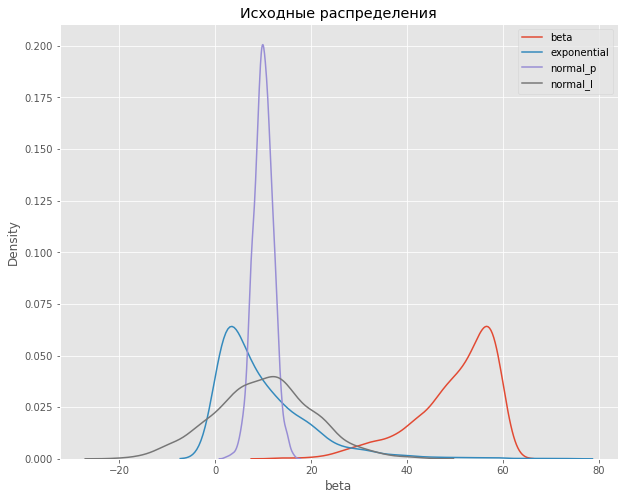

In [597]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['beta'], ax=ax1, label ='beta')
sns.kdeplot(df['exponential'], ax=ax1, label ='exponential')
sns.kdeplot(df['normal_p'], ax=ax1, label ='normal_p')
sns.kdeplot(df['normal_l'], ax=ax1, label ='normal_l')
plt.legend()

Признаки распределены по-разному: смещены влево, вправо, присутствуют отрицательные величины. Попробуем нормализовать их.

Зафиксируем описательные статистики до преобразований

In [598]:
df.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745
std,8.474545,9.733928,2.013971,10.104004
min,13.854022,0.007617,2.356844,-19.539980
25%,45.793283,2.951421,8.687478,3.566822
50%,52.337504,7.018565,9.983498,10.326331
75%,56.722191,14.022485,11.306914,16.615057
max,59.990640,71.344341,16.214364,42.072915


#### MINMAXSCALER

При применении нормализации методом MinMaxScaler все значения признаков будут преобразованы в диапазон [0,1], что означает, что минимальное и максимальное значение признака будет равно 0 и 1 соответственно.

Нормализация происходит следующим способом:

1. Из каждого значения признака х вычитается минимальное значение этого признака: x – min
2. Результат вычитания делится на между максимумом и минимумом признака: max – min

Например, температура в горном посёлке за день может меняться от 10 до 35 градусов. Текущая температура составляет 17 градусов. 

Xscaled = (17 - 10) / (35 - 10) = 0.28

Нормализованное значение 0.28 лежит в диапазоне от 0 до 1, и ближе к левой границе распределения (0), что соответствует также ненормализованному распределению (значение 17 ближе к 10).

<AxesSubplot:title={'center':'После нормализации MinMaxScaler'}, xlabel='beta', ylabel='Density'>

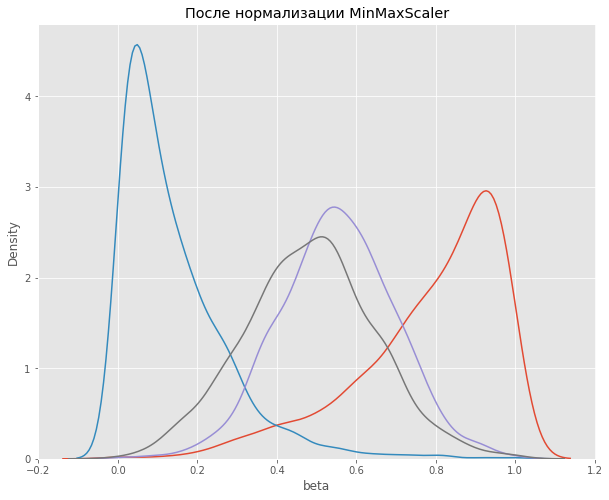

In [599]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)

#### ROBUSTSCALER

Нормализация методом RobustScaler происходит в несколько этапов:

1. из каждого значения признака вычитается медиана признака: (x – медиана)
2. полученное значение делится на межквартильный размах: (значение 75% – значение 25%)

Например, имеется числовой ряд [1, 2, 3, 4, 5]. Медиана ряда — 3. Межквартильный размах: . Мы хотим нормализовать число 4.

Xscaled = (4 - 3) / 2 = 0.5

Таким образом, значение 4 после нормализации приняло значение 0.5.

<AxesSubplot:title={'center':'Распределения после RobustScaler'}, xlabel='beta', ylabel='Density'>

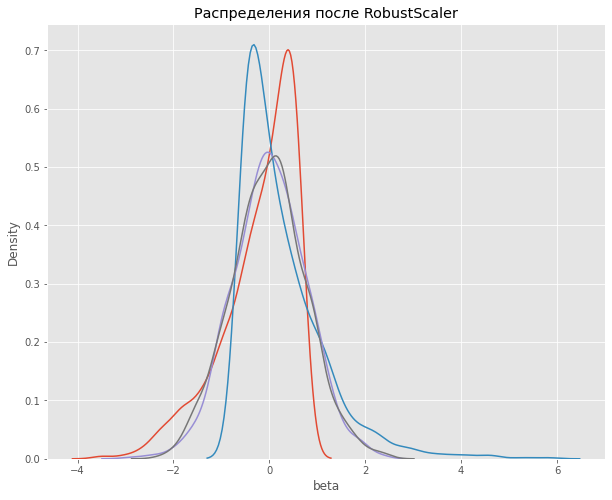

In [600]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax1)
sns.kdeplot(df_r['exponential'], ax=ax1)
sns.kdeplot(df_r['normal_p'], ax=ax1)
sns.kdeplot(df_r['normal_l'], ax=ax1)

#### В ЧЁМ РАЗНИЦА?
Поскольку MinMaxScaler использует в своём вычислении минимальное и максимальное значения признака, то этот способ будет чувствителен к наличию выбросов в распределении.

RobustScaler в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов.

Поэтому, если ваши данные уже были очищены от выбросов, смело используйте MinMaxScaler. Этот алгоритм нормализации используется специалистами по данным чаще всего в силу его простоты и понятности, а данные на этом этапе чаще всего уже очищены. Если вы пропустили этап очистки данных и нормализуете признаки раньше, используйте нормализатор RobustScaler.

Больше о других способах нормализации и их сравнении вы можете прочитать в официальном руководстве scikit-learn: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

### СТАНДАРТИЗАЦИЯ

Стандартизация — ещё один метод преобразования входных признаков, при котором изменяется распределение таким образом, чтобы среднее значений равнялось 0, а стандартное отклонение — 1. 

Xscaled = (X - Xmean) / Xstd, где Xstd – стандартное отклонение

Например, у нас есть числовой ряд [1, 2, 3, 4, 5]. Среднее ряда: 3. Стандартное отклонение — 1.4. Нормализуем число 4.

Xscaled = (4-3) / 1.4 = 0.7

Нормализованное число 4 равно 0.7.

<AxesSubplot:title={'center':'Распределения после StandardScaler'}, xlabel='beta', ylabel='Density'>

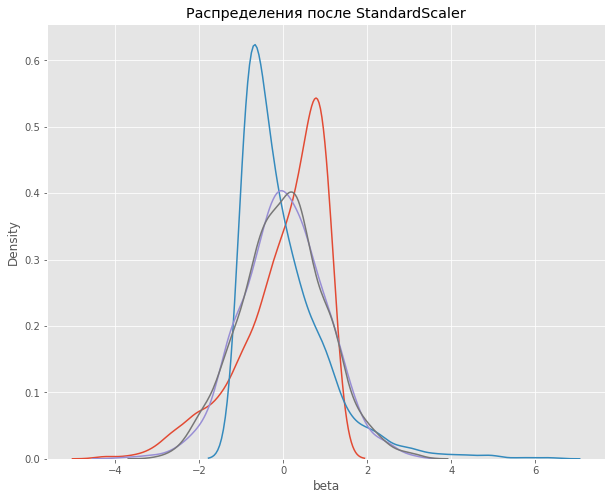

In [601]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
df_s = s_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1)


#### НОРМАЛИЗОВАТЬ ИЛИ СТАНДАРТИЗИРОВАТЬ?

* если признак распределён нормально, то его необходимо стандартизировать;
* если признак распределён ненормально, его необходимо нормализовать;
* если разброс значений небольшой, то можно обойтись без преобразования данных.

### 6.3

Нормализуйте признак price. Используйте подходящий тип нормализации.

В ответе напишите результат выполнения кода data['price'].sum(), округлённый до целого.

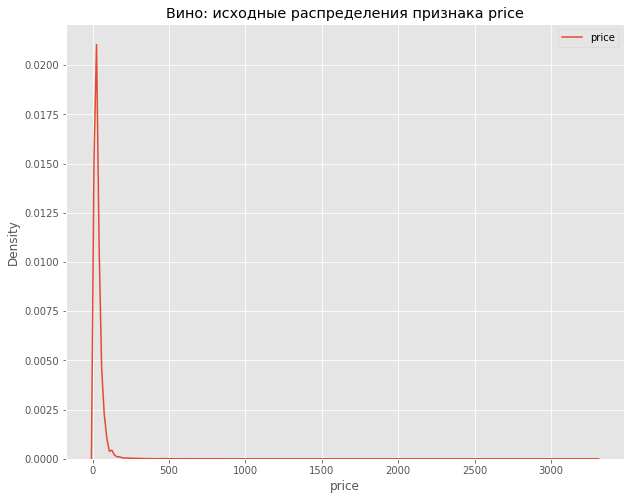

In [602]:
data_norm = pd.read_csv('data/wine_cleared.csv')

# зададим параметры холста, название и визуализируем кривые распределения:
fig_wine, (ax1_wine) = plt.subplots(ncols=1, figsize=(10, 8))
ax1_wine.set_title('Вино: исходные распределения признака price')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data_norm['price'], ax=ax1_wine, label ='price')
plt.legend()

43501.229482424984

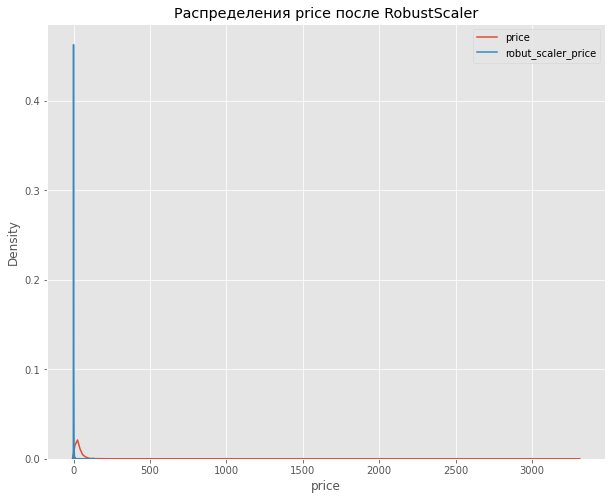

In [603]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
data_r = r_scaler.fit_transform(pd.DataFrame(data_norm['price']))

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_r = pd.DataFrame(data_r, columns=['robut_scaler_price'])
data_norm = pd.concat([data_norm, data_r], axis=1)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения price после RobustScaler')

sns.kdeplot(data_norm['price'], ax=ax1, label='price')
sns.kdeplot(data_norm['robut_scaler_price'], ax=ax1, label='robut_scaler_price')
plt.legend()

# В ответе напишите результат выполнения кода data['price'].sum(), округлённый до целого.
data_norm['robut_scaler_price'].sum()

### 6.5
Стандартизируйте исходный признак price.

В ответе напишите результат выполнения кода data['price'][129968]. Ответ округлите до сотых.

-0.13551812448719314

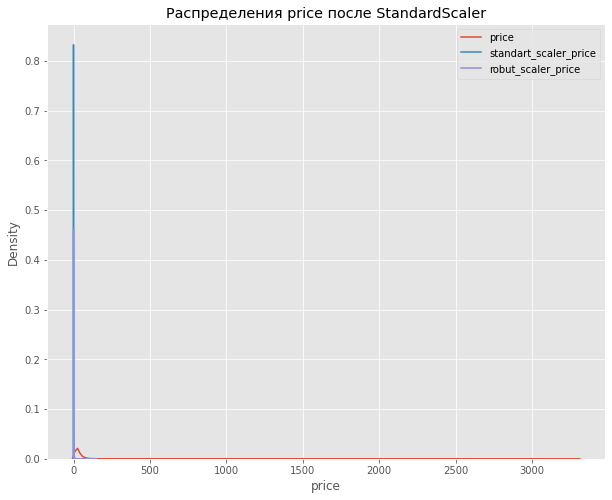

In [604]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
data_s = s_scaler.fit_transform(pd.DataFrame(data_norm['price']))

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
data_s = pd.DataFrame(data_s, columns=['standart_scaler_price'])
data_norm = pd.concat([data_norm, data_s], axis=1)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения price после StandardScaler')

sns.kdeplot(data_norm['price'], ax=ax1, label='price')
sns.kdeplot(data_norm['standart_scaler_price'], ax=ax1, label='standart_scaler_price')
sns.kdeplot(data_norm['robut_scaler_price'], ax=ax1, label='robut_scaler_price')
plt.legend()

# В ответе напишите результат выполнения кода data['price'][129968]. Ответ округлите до сотых.
data_norm['standart_scaler_price'][129968]


## Отбор признаков. Мультиколлинеарность

Отбор признаков — процесс выбора важных признаков, наиболее влияющих на предсказание.

Существует множество методов для отбора признаков. Однако для их использования необходимо понимать такие понятия, как значимость, критерий значимости, гипотеза,  мультиколлинеарность.

Мультиколлинеарность — сильная корреляционная связь между признаками, отбираемыми для обучения. 

Сильно скоррелированные признаки сообщают для модели одну и ту же информацию. Поэтому для обучения не нужно использовать их все. Часть из них необходимо удалить из набора данных. 

Рассмотрим учебный датасет.

Данные содержат 150 экземпляров ириса, по 50 экземпляров трех видов — Ирис щетинистый (Iris setosa), Ирис виргинский (Iris virginica) и Ирис разноцветный (Iris versicolor). Для каждого экземпляра измерялись четыре характеристики (в сантиметрах):

* sepal length — длина наружной доли околоцветника;
* sepal width — ширина наружной доли околоцветника;
* petal length — длина внутренней доли околоцветника;
* petal width — ширина внутренней доли околоцветника.

In [605]:
# import pandas as pd

iris = pd.read_csv('data/iris.zip')
iris.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


<AxesSubplot:>

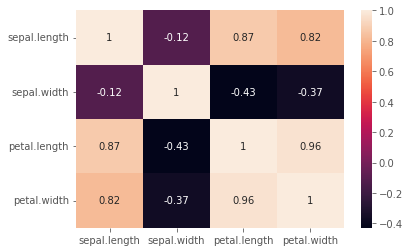

In [606]:
# import seaborn as sns # импортируем seaborn для построения графиков
sns.heatmap(iris.corr(), annot=True) # включаем отображение коэффициентов

Как мы выяснили из тепловой карты корреляций, у нас есть три пары сильно скоррелированных признаков: sepal.length и petal.width, petal.length и sepal.length, petal.width и petal.length.

Начнём с самого высокого коэффициента корреляции в паре признаков: petal.width и petal.length 0,96. Удалим любой признак из этой пары, например petal.width, так как он коррелирует ещё и с признаком sepal.length:

In [607]:
iris = iris.drop(['petal.width'], axis=1)

Однако второй признак petal.length из этой пары также сильно коррелирует с признаком sepal.length. Удалим и его:

In [608]:
iris = iris.drop(['petal.length'], axis=1)

Посмотрим на результат:

In [609]:
iris.head()

,sepal.length,sepal.width,variety
0,5.1,3.5,Setosa
1,4.9,3.0,Setosa
2,4.7,3.2,Setosa
3,4.6,3.1,Setosa
4,5.0,3.6,Setosa


Какие из признаков датасета вин имеют самую сильную корреляционную связь?

<AxesSubplot:>

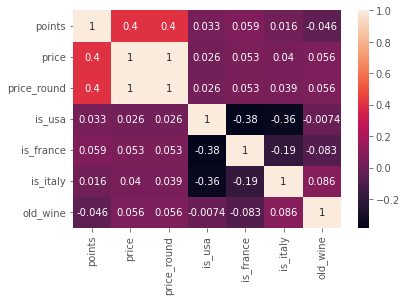

In [610]:
sns.heatmap(data[['points','price','price_round','is_usa','is_france','is_italy','old_wine']].corr(), annot=True) # включаем отображение коэффициентов

In [611]:
# # import pandas as pd
# def get_correlated(corr_matrix, thres=0.7):
#     """Getting correlated pairs from a correlation matrix 
#        with correlation coefficients higher than the threshold
#     Args:
#         corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
#         thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).
#     Returns:
#         pandas Series: correlated pairs and correlation coefficients
#     """
    
#     correlated_pairs = {}
    
#     for col in corr_matrix.columns:
#         positive_filter = corr_matrix[col] >= thres
#         negative_filter = corr_matrix[col] <= -thres
#         match_series = corr_matrix[col][positive_filter | negative_filter]
#         for match in match_series.index:
#             if match != col and match + ' -- ' + col not in correlated_pairs.keys():
#                 correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
#     return pd.Series(correlated_pairs).sort_values()


# test_data = data[['points','price','price_round','is_usa','is_france','is_italy','old_wine']]
# get_correlated(test_data)

In [612]:
data.drop(['price'], axis=1, inplace=True)

<AxesSubplot:>

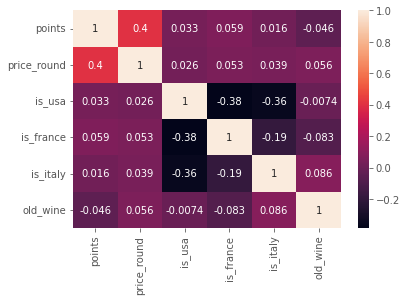

In [613]:
sns.heatmap(data[['points','price_round','is_usa','is_france','is_italy','old_wine']].corr(), annot=True) # включаем отображение коэффициентов